In [1]:
using CSV, DataFrames, Statistics, Clustering, Plots, Random, Gurobi, JuMP, DataStructures, StatsBase

In [2]:
data_prev = CSV.read("data/pred_Maria.csv",DataFrame)
data_opti = CSV.read("data/opti_Maria.csv",DataFrame)
pred_logistic = CSV.read("data/pred_lr.csv",DataFrame)[:, "0"];

In [3]:
#number booked appointments
na = nrow(data_prev)
#number new appointments
nb = nrow(data_opti)
ntot = na + nb
#number doctors
nd = 15
#penalty added nurse
pen_nurse = 5
#penalty hole
pen_hole = 3

3

In [4]:
na_1 = Int(floor(na/15))
nb_1 = Int(floor(nb/15))
ntot_1 = na_1 + nb_1
idx_prev = rand(1:na, na_1)
idx_opti = rand(1:nb, nb_1)
idx_predictions = [idx_prev;idx_opti .+ na]
pred_logistic_1 = pred_logistic[idx_predictions]
data_prev_1 = data_prev[idx_prev,:]
data_opti_1 = data_opti[idx_opti,:];

In [33]:
#previously_booked
s = data_prev_1.slot .+1 ;
#available
a = Matrix(data_opti_1[:,121:125]);

In [35]:
function optim_add_nurse_hole(p)
    model = Model(with_optimizer(Gurobi.Optimizer, TimeLimit=180))
    set_optimizer_attribute(model, "OutputFlag", 0)

    @variable(model, x[1:ntot_1, 1:50], Bin)
    @variable(model, t[1:50])
    @variable(model, u[1:50])

    @objective(model, Min, sum(t)*pen_nurse + sum(u)*pen_hole)

    @constraint(model, [j=1:50], t[j] >= sum(x[i,j]*p[i,j] for i=1:ntot_1) - nd) 
    @constraint(model, [j=1:50], t[j] >= 0)

    for d=1:5
        for j=2:9
            h = (d-1)*10 + j
            #@constraint(model, u[h] >= sum(p[i,h]*x[i,h] for i=1:ntot_1) - min(sum(p[i,h-1]*x[i,h-1] for i=1:ntot_1), sum(p[i,h+1]*x[i,h+1] for i=1:ntot_1)))
            @constraint(model, u[h] >= - sum(p[i,h]*x[i,h] for i=1:ntot_1) + sum(p[i,h-1]*x[i,h-1] for i=1:ntot_1))
            @constraint(model, u[h] >= - sum(p[i,h]*x[i,h] for i=1:ntot_1) + sum(p[i,h+1]*x[i,h+1] for i=1:ntot_1))
            @constraint(model, u[h] >= 0)
        end
            @constraint(model, u[(d-1)*10 + 10] == 0)
            @constraint(model, u[(d-1)*10 + 1] == 0)
    end

    for i=1:na_1
        for j=1:50
            if s[i]==j
                @constraint(model, x[i,j] == 1)
            else
                @constraint(model, x[i,j] == 0)
            end
        end
    end

    for i=na_1+1:ntot_1
        for j=1:50
            if j in a[i-na_1,:]
            else
                @constraint(model, x[i,j] == 0)
            end
        end
    end

    @constraint(model, [i=1:ntot_1], sum(x[i,j] for j=1:50) == 1)


    optimize!(model)
    return objective_value(model), JuMP.value.(x)
end

optim_add_nurse_hole (generic function with 1 method)

In [36]:
p_oracle = ones(ntot_1,50)
for i = 1:na_1
    for j=1:50
        p_oracle[i,j] = 1 - data_prev_1.NoShow[i]
    end
end
for i = na_1+1:ntot_1
    for j=1:50
        p_oracle[i,j] = 1 - data_opti_1.NoShow[i-na_1]
    end
end

In [37]:
o, x_o = optim_add_nurse_hole(p_oracle)
o

Academic license - for non-commercial use only - expires 2022-08-18


32.999997598425566

In [38]:
p_random = rand(ntot_1, 50);
_, x_r = optim_add_nurse_hole(p_random)

Academic license - for non-commercial use only - expires 2022-08-18


(22.31723943561837, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [39]:
p_logistic = ones(ntot,50)
for i = 1:na
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i]
    end
end
for i = na+1:ntot
    for j=1:50
        p_logistic[i,j] = 1 - pred_logistic[i-na]
    end
end

In [40]:
_, x_l = optim_add_nurse_hole(p_logistic)

Academic license - for non-commercial use only - expires 2022-08-18


(26.970998209543797, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

### Comparison of schedules

In [41]:
s_logistic = reshape(sum(x_l[i,:] for i=1:ntot_1), (10,5))

10×5 Matrix{Float64}:
 1.0  0.0  0.0  1.0  1.0
 2.0  1.0  2.0  2.0  2.0
 2.0  1.0  2.0  2.0  3.0
 2.0  1.0  2.0  2.0  2.0
 2.0  2.0  2.0  1.0  1.0
 1.0  1.0  2.0  1.0  1.0
 2.0  1.0  2.0  2.0  1.0
 2.0  1.0  2.0  1.0  1.0
 2.0  1.0  2.0  2.0  1.0
 0.0  2.0  0.0  3.0  1.0

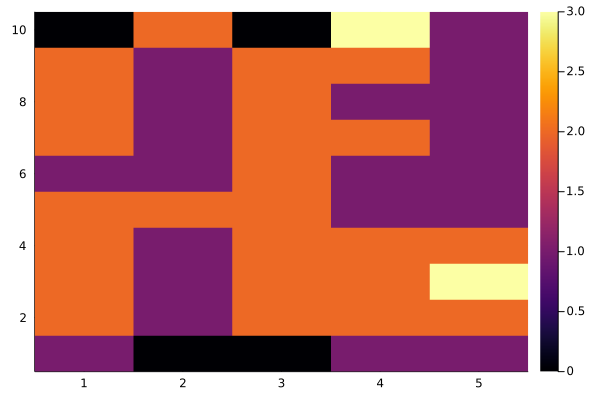

In [42]:
heatmap(s_logistic)

In [43]:
s_logistic_show = reshape([sum(x_l[i,j]*p_oracle[i,j] for i=1:ntot_1) for j=1:50], (10,5));

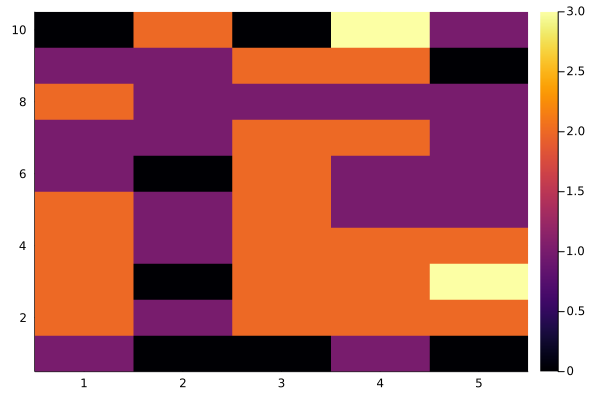

In [44]:
heatmap(s_logistic_show)

In [45]:
s_o = reshape(sum(x_o[i,:] for i=1:ntot_1), (10,5))

10×5 Matrix{Float64}:
 1.0  0.0  0.0  1.0  1.0
 2.0  0.0  2.0  2.0  3.0
 2.0  1.0  2.0  2.0  3.0
 2.0  1.0  2.0  2.0  1.0
 2.0  2.0  2.0  1.0  1.0
 2.0  2.0  2.0  1.0  0.0
 2.0  1.0  2.0  2.0  1.0
 1.0  1.0  3.0  1.0  1.0
 2.0  1.0  1.0  2.0  2.0
 0.0  2.0  0.0  3.0  1.0

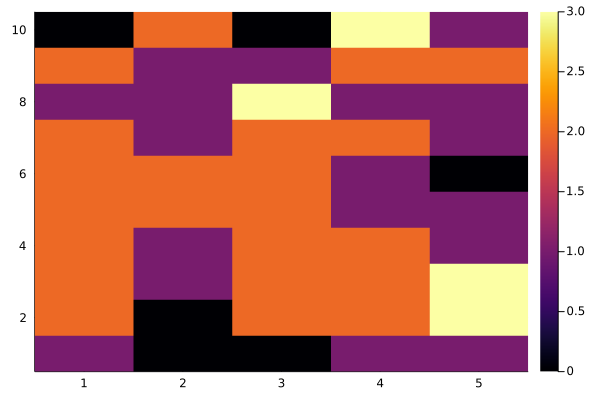

In [46]:
heatmap(s_o)

In [47]:
s_o_show = reshape([sum(x_o[i,j]*p_oracle[i,j] for i=1:ntot_1) for j=1:50], (10,5));

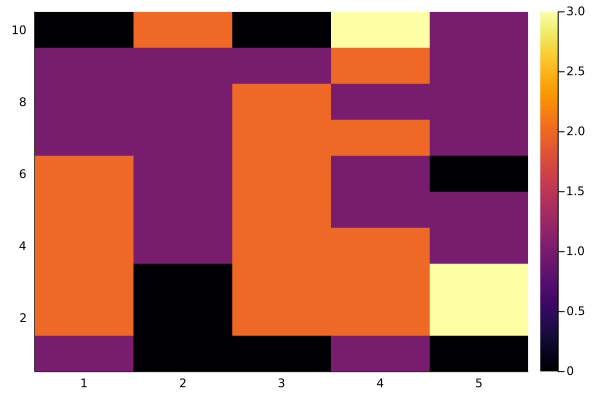

In [48]:
heatmap(s_o_show)

In [49]:
s_random = reshape(sum(x_r[i,:] for i=1:ntot_1), (10,5))
s_random_show = reshape([sum(x_r[i,j]*p_oracle[i,j] for i=1:ntot_1) for j=1:50], (10,5));

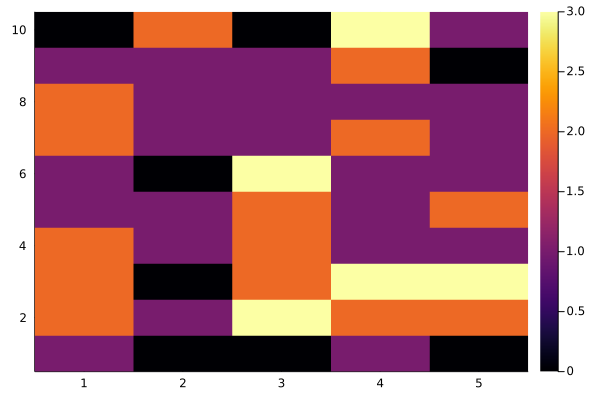

In [50]:
heatmap(s_random_show)